In [1]:
import matplotlib.pyplot as plt
import math
import random
import itertools
import datetime
import numpy as np
import randomcolor
import seaborn as sns
import dask.array as da
import dask.bag as db
import dask
from tqdm.notebook import trange, tqdm, tqdm_notebook
colors = list(sns.color_palette('bright'))
rng = np.random.default_rng()
rng_seed = np.random.default_rng()

In [3]:
from base import *
from game import *
from rules import *
from sim import *
from helper import *

In [79]:
# seed = rng_seed.integers(0, 2 ** 24)
seed = 11507
print("Seed: ", seed)
rng = np.random.default_rng(seed)

n, m = 2, 3
# mg = MultilinearGame(np.array([[[1.]],[[-1.]]]).astype(float))
# mg = MultilinearGame(np.array([[[1,0,0],[0,1,0],[0,0,1]],[[0,1,0],[0,1,1],[1,0,0]]]))
# mg = MultilinearGame(np.array([[[1,0,0],[0,1,0],[0,0,1]],[[0,1,0],[0,0.95,1],[1,0,0]]]))
# mg = MultilinearGame(zero_sum(rng, size=(m,) * n))
mg = MultilinearGame(rng.uniform(low=-1.0, high=1.0, size=((n,) + (m,) * n)))
# my_proj = ProjDimension(np.array([-30],float))
# my_proj = ProjDimension(np.array([-.2, -.25, -.33]))
my_proj = proj_sim

eta = 0.1

# paper
# learner = OFTRL(lr=eta, proj=my_proj, barrier=log_barrier, optimism=1)
# learner = BlumMansour(OFTRL(lr=eta, proj=my_proj, barrier=log_barrier))

# GD
# learner = GradientDescent(lr=eta, proj=my_proj)
# learner = BlumMansour(GradientDescent(lr=eta, proj=my_proj)) # BAD

# OG EG
# learner = OptimisticGradient(lr=eta, proj=my_proj)
# learner = ExtraGradient(lr=eta, proj=my_proj)
learner = MultiExtraGradient(lr=eta, proj=my_proj, steps=5)
# learner = BlumMansour(OptimisticGradient(lr=eta, proj=my_proj))

# MWU
# learner = MultiplicativeWeightUpdate(lr=eta, proj=my_proj, optimism=0)

# OFTRL ODA
# learner = OFTRL(lr=eta, proj=my_proj, barrier=l2_regularizer, optimism=1)
# learner = OFTRL_l2(lr=eta,proj=my_proj,optimism=0)
# learner = OFTRL_l2(lr=eta,proj=my_proj,optimism=1)
# learner = ODA_l2(lr=eta,proj=my_proj,optimism=0)
# learner = BlumMansour(OFTRL_l2(lr=eta,proj=my_proj))

# learner = Alternating(learner)

# init_state = np.array([[0.1,0.2,0.31],[0.3,0.44,0.22]],float))
init_state = np.ones((n,m))
sim = GameSim(mg, learner, my_proj, [], init_state=my_proj(init_state))
# sim = GameSim(mg, learner, my_proj, [None, "swap"])

Seed:  11507


In [80]:
%%time
sim.play(12000)

CPU times: total: 141 ms
Wall time: 1.71 s


C:\Users\etaoi\anaconda3\envs\py310\lib\statistics.py:190: RuntimeWarning: overflow encountered in long_scalars
  partials[d] = partials_get(d, 0) + n


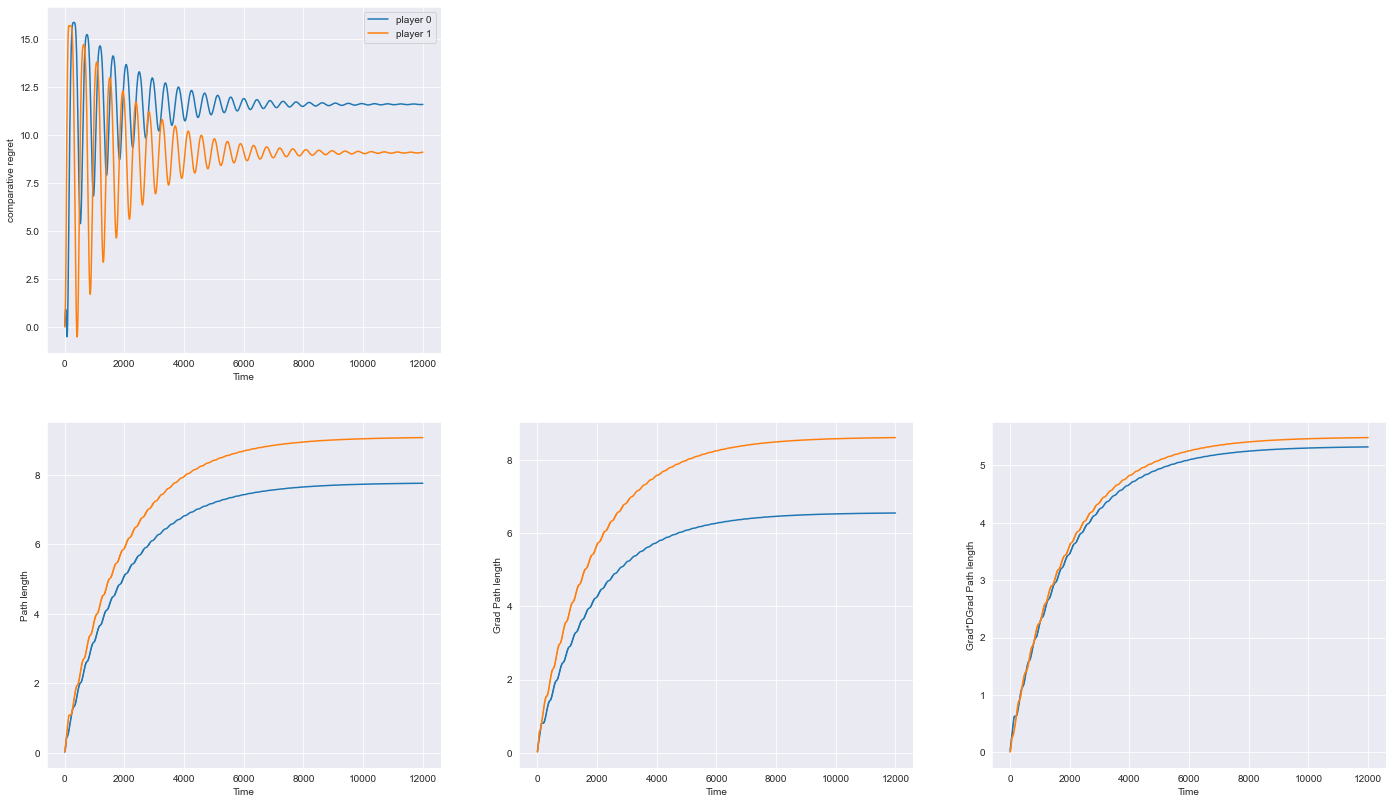

In [81]:
nonnegative = False
# pure = np.array([0,-30],float).reshape((-1,1))
pure = 'last'
fig, axs = plt.subplots(2, 3, figsize=(24, 14))
(ax1s, (ax_pl, ax_gpl, ax_gdpl)) = axs
for ax in axs.flat:
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    pass

for i, mode in enumerate(["comparative", None, "swap"]):
    if i == 0 or mode in sim.regret_types:
        if i == 0:
            regrets = sim.normed_regret_recorder(pure=pure)
        else:
            regrets = sim.regret_recorders[mode]()
        if nonnegative:
            regrets = np.maximum(regrets, 0)
        ax1s[i].plot([(i + 1) for i in range(regrets.shape[1])], regrets.transpose(), label=[f"player {i}" for i in range(regrets.shape[0])])
        ax1s[i].legend()
        # ax1s[i].plot([(i + 1) for i in range(regrets.shape[1])], [math.sqrt(i + 1) for i in range(regrets.shape[1])])
        # plt.xscale("log")
        ax1s[i].set_xlabel("Time")
        ax1s[i].set_ylabel(f"{mode if mode else 'External'} regret")
    else:
        ax1s[i].axis('off')

def temp_func(sim: GameSim):
    whole_steps = np.array([a.internal for a in sim.trajectory])
    half_steps = np.array([a.state for a in sim.trajectory])
    grads = np.array([a.grad for a in sim.trajectory])
    gee = ((np.diff(grads, axis=0) ** 2).sum(axis=2) * eta * eta - ((whole_steps - half_steps)[1:,:,:] ** 2).sum(axis=2))
    return gee

# path_length = temp_func(sim).cumsum(axis=0) / (2 * eta)
# ax2.plot([(i + 1) for i in range(path_length.shape[0])], path_length)
# ax2.set_xlabel("Time")
# ax2.set_ylabel("Temp")
#
# ax3 = ax1s[3]
# def regret_bound(sim: GameSim):
#     x_star = np.swapaxes(sim.regret_recorders[None].x_star(),0,1)
#     x0 = sim.trajectory[0].state
#     xt = np.array([x.state for x in sim.trajectory])
#     return ((norm_sq(x0 - x_star, axis=-1) - norm_sq(xt - x_star, axis=-1))[1:] + temp_func(sim).cumsum(axis=0)) / (2 * eta)
# reg_bound = regret_bound(sim)
# ax3.plot([(i + 1) for i in range(path_length.shape[0])], reg_bound)
# ax3.set_xlabel("Time")
# ax3.set_ylabel("Regret Bound")

path_length = sim.path_length(order=2,power=1)
ax_pl.plot([(i + 1) for i in range(path_length.shape[0])], path_length)
ax_pl.set_xlabel("Time")
ax_pl.set_ylabel("Path length")

path_length = sim.grad_path_length(order=2,power=1)
ax_gpl.plot([(i + 1) for i in range(path_length.shape[0])], path_length)
ax_gpl.set_xlabel("Time")
ax_gpl.set_ylabel("Grad Path length")

path_length = (lambda t: np.cumsum(np.linalg.norm(t[1:], axis=2) *
                                   np.linalg.norm(np.diff(t, axis=0), axis=2),
                                   axis=0)) \
    (np.array([a.grad for a in sim.trajectory]))
ax_gdpl.plot([(i + 1) for i in range(path_length.shape[0])], path_length)
ax_gdpl.set_xlabel("Time")
ax_gdpl.set_ylabel("Grad*DGrad Path length")


None

In [78]:
path_length = sim.path_length(order=2,power=1)

def path_ratio(path_length):
    t = path_length.shape[0]
    delta = path_length[t-1] - path_length[t // 2]
    if np.max(delta) < 1e-9:
        return np.max(delta), tuple(delta)
    norm_delta = delta / np.max(delta)
    return np.max(delta), tuple(norm_delta)

path_ratio(path_length)

(0.8890759785139148, (0.455586912415538, 1.0))

C:\Users\etaoi\anaconda3\envs\py310\lib\statistics.py:190: RuntimeWarning: overflow encountered in long_scalars
  partials[d] = partials_get(d, 0) + n


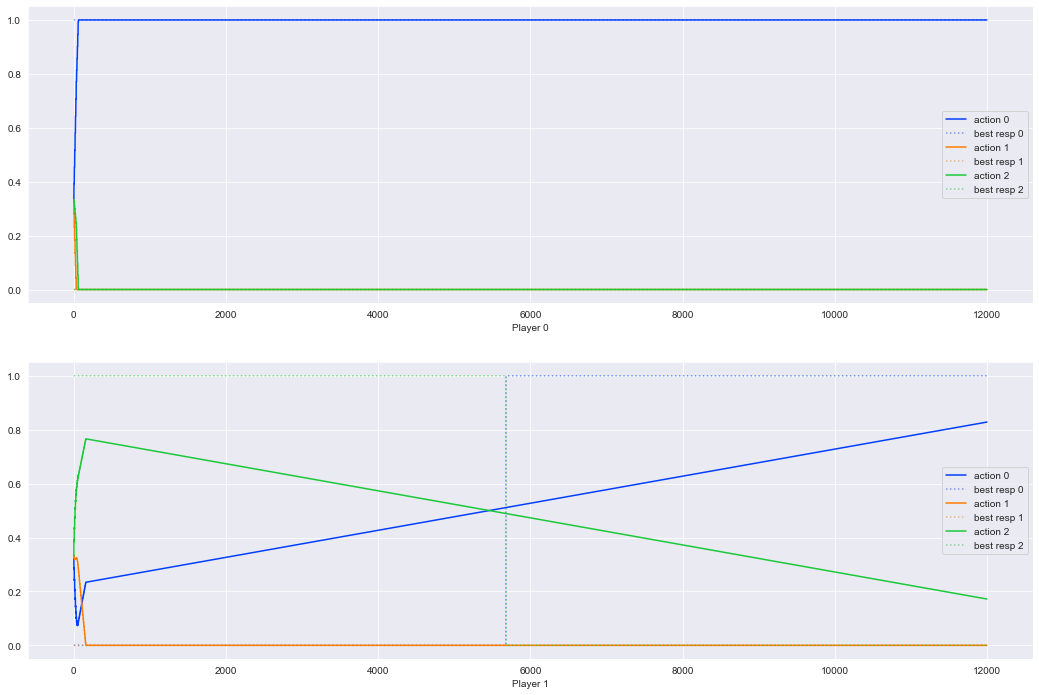

In [62]:
# Show play trajectories
n, m, *_ = mg.weight.shape
n1 = math.ceil(math.sqrt(n))
n2 = math.ceil(n / n1)
fig, axss = plt.subplots(n1, n2, figsize=(18,12))
axs = axss.flat
x_star = sim.normed_regret_recorder.x_star()
for i, ax in enumerate(axs):
    if i < n:
        tmp = np.array([a[i] for a, *_ in sim.trajectory])
        for j in range(m):
            ax.plot(tmp[:,j], label="action {}".format(j),color=colors[j])
            ax.plot(x_star[i,:,j], linestyle=':',label="best resp {}".format(j),color=colors[j],alpha=0.5)
        ax.legend()
        ax.set_xlabel("Player {}".format(i))
    else:
        ax.axis(False)


In [8]:
if False:
    x, y = sim.point_trajectory().reshape(-1,2).transpose()
    fig, ax = plt.subplots()
    ax.scatter(x[::2], y[::2],label="player 0")
    ax.scatter(x[1::2], y[1::2],label="player 1")
    ax.legend()
x, y = sim.point_trajectory()[:,1,:].transpose()
fig, ax = plt.subplots()
ax.scatter(x[::2], y[::2],label="action 0")
ax.scatter(x[1::2], y[1::2],label="action 1")
ax.legend()

ValueError: too many values to unpack (expected 2)

In [ ]:
# Show 3D play trajectories
n, m, *_ = mg.weight.shape
if m == 3:
    n1 = math.ceil(math.sqrt(n))
    n2 = math.ceil(n / n1)
    fig, axss = plt.subplots(n1, n2, figsize=(18,12), subplot_kw=dict(projection='3d'))
    axs = axss.flat
    x_star = sim.normed_regret_recorder.x_star()
    for i, ax in enumerate(axs):
        if i < n:
            tmp = np.array([a[i] for a, *_ in sim.trajectory]).transpose()
            ax.elev = 10
            ax.azim = 15
            ax.plot3D(*tmp)
            ax.legend()
            ax.set_xlabel("action 0")
            ax.set_ylabel("action 1")
            ax.set_zlabel("action 2")
            ax.set_title("Player {}".format(i))
        else:
            ax.axis(False)
plt.tight_layout()

C:\Users\etaoi\Desktop\gamesim\sim.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pure == 'last':


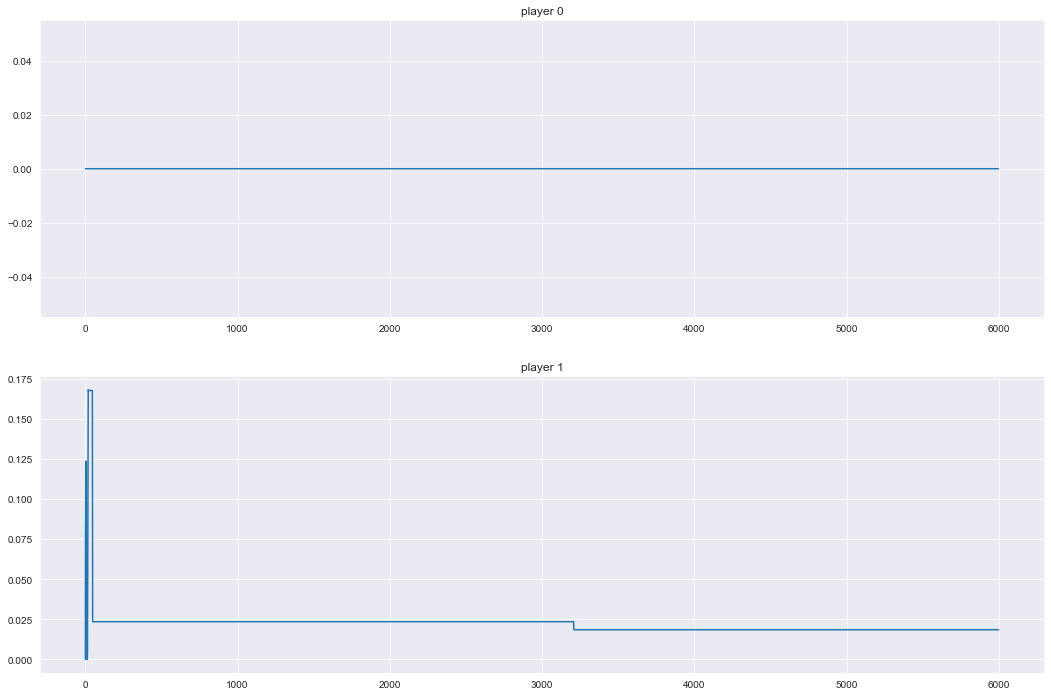

In [9]:
pure_point = np.ones((n,m)) * 0.5
pure_regret = sim.normed_regret_recorder(pure=pure_point)
pure_traj = sim.point_trajectory()
pure_eval = norm_sq(pure_traj - pure_point, axis=-1) / eta + pure_regret.transpose()
# pure_eval = norm_sq(pure_traj - pure_point, axis=-1) / eta
# pure_eval = -pure_regret.transpose()

pure_eval = np.diff(pure_eval, axis=0)

pure_eval = pure_eval[:-1:2] + pure_eval[1::2]

pure_eval = np.maximum(0, pure_eval)

fig, axes = plt.subplots(n, 1, figsize=(18, 12))
for i in range(n):
    axes.flat[i].plot(pure_eval[:,i])
    axes.flat[i].set_title("player {}".format(i))

In [7]:
from dask.distributed import Client

client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 31.61 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50081,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 31.61 GiB
Comm: tcp://127.0.0.1:50118,Total threads: 2
Dashboard: http://127.0.0.1:50119/status,Memory: 7.90 GiB
Nanny: tcp://127.0.0.1:50084,


  0%|          | 0/60 [00:00<?, ?it/s]

C:\Users\etaoi\anaconda3\envs\py310\lib\statistics.py:190: RuntimeWarning: overflow encountered in long_scalars
  partials[d] = partials_get(d, 0) + n


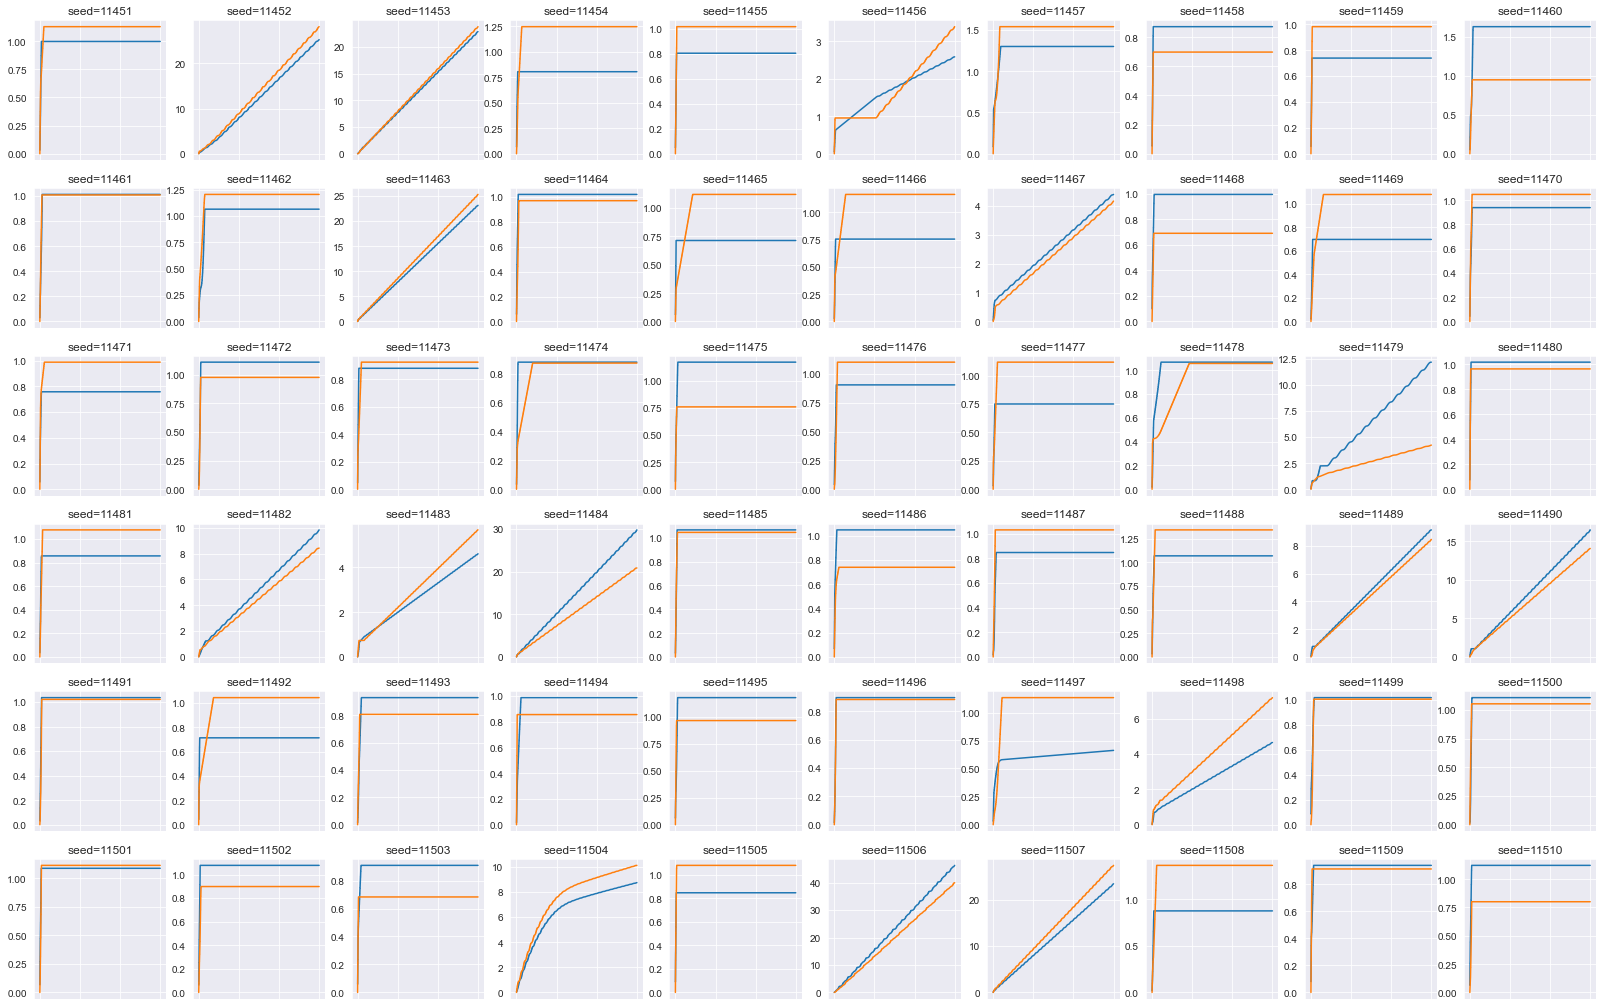

In [73]:
n, m = 2, 3
eta = 0.1
# my_proj = ProjDimension(np.array([-0.2,-0.2]))
my_proj = proj_sim

seeds = db.from_sequence(np.arange(0, 60) + 11451, partition_size=1)

def do_experiment(here_seed):
    here_rng = np.random.default_rng(here_seed)
    # mg = MultilinearGame(zero_sum(here_rng, size=(m,) * n))
    mg = MultilinearGame(here_rng.uniform(low=-1.0, high=1.0, size=((n,) + (m,) * n)))
    learner = GradientDescent(lr=eta, proj=my_proj)
    # learner = MultiplicativeWeightUpdate(lr=eta, proj=my_proj, optimism=0)
    # learner = OptimisticGradient(lr=eta,proj=my_proj)
    # learner = ExtraGradient(lr=eta,proj=my_proj)
    # learner = MultiExtraGradient(lr=eta,proj=my_proj,steps=3)
    learner = Alternating(learner)
    sim = GameSim(mg, learner, my_proj, [], init_state=my_proj(np.array([[0.1,0.2,0.31],[0.3,0.44,0.22]])))
    sim.play(3000)
    path_length = sim.path_length(order=2,power=1)
    return here_seed, sim, path_length

sims = seeds.map(do_experiment)

sims = sims.compute()

fig, axs = plt.subplots(6, 10, figsize=(28, 18))
for i, ax in enumerate(tqdm(axs.flat)):
    here_seed, sim, path_length = sims[i]

    # regrets = sim.normed_regret_recorder(pure='last')
    # regrets = sim.point_trajectory()[:,0,:].transpose()
    # ax.plot([(i + 1) for i in range(regrets.shape[1])], regrets.transpose())

    ax.plot([(i + 1) for i in range(path_length.shape[0])], path_length)

    ax.set_title("seed={}".format(here_seed))
    # ax.set_ylim(-5, 8)
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

In [ ]:
mmg = MultilinearGame(rng.uniform(size=((n,) + (m,) * n)))
mreg: float = -114514
my_proj = proj_l2ball
eta = 0.1
init_time = datetime.datetime.now()
last_output_time = init_time
for i in range(114514):
    this_output_time = datetime.datetime.now()
    if (this_output_time - last_output_time).total_seconds() > 5:
        print("Iteration {} at {}".format(i, this_output_time - init_time))
        last_output_time = this_output_time
    n = 2
    m = 10
    mg = MultilinearGame(rng.uniform(low=-1.0, high=1.0, size=((n,) + (m,) * n)))
    learner = OptimisticGradient(lr=eta, proj=my_proj)
    sim = GameSim(mg, learner, proj=my_proj)
    sim.play(300)
    regrets = sim.regret_recorders['normed']()
    reg: float = regrets.max()
    if reg > mreg:
        mreg = reg
        mmg = mg
        print(reg)

## Data

In [40]:
mg = MultilinearGame(np.array([[[0.67042628, 0.39706957, 0.42964484, 0.61247737],
        [0.15414972, 0.20789047, 0.27953194, 0.0516548 ],
        [0.22295242, 0.90496207, 0.32473093, 0.35545632],
        [0.52555539, 0.38924423, 0.07948948, 0.91891865]],

       [[0.8568959 , 0.95730921, 0.33579909, 0.1684858 ],
        [0.63496624, 0.43562002, 0.86900799, 0.20695073],
        [0.95044942, 0.34200397, 0.98677491, 0.38937916],
        [0.52566604, 0.27494413, 0.81210686, 0.91234926]]]))

In [35]:
mg = MultilinearGame(np.array([[[[0.38725044, 0.34240753, 0.02810337],
         [0.55074954, 0.60687508, 0.69976101],
         [0.59657795, 0.46950552, 0.27485584]],
        [[0.09728714, 0.60672773, 0.54360432],
         [0.26454208, 0.25278358, 0.50165633],
         [0.04169336, 0.11747752, 0.49429097]],
        [[0.77173717, 0.86346229, 0.3505611 ],
         [0.35594837, 0.31400333, 0.64525392],
         [0.55258491, 0.53210521, 0.04410721]]],
       [[[0.73805032, 0.30159735, 0.84759458],
         [0.04005955, 0.11278326, 0.84749458],
         [0.64340064, 0.04897343, 0.61148755]],
        [[0.35718986, 0.67194212, 0.51199374],
         [0.39911936, 0.94905635, 0.50967383],
         [0.66591209, 0.88617184, 0.55056259]],
        [[0.45704226, 0.90936315, 0.90983527],
         [0.50159104, 0.18228659, 0.30326444],
         [0.3209547 , 0.3873199 , 0.47680925]]],
       [[[0.65115376, 0.47580537, 0.35108451],
         [0.88925328, 0.10580608, 0.90254684],
         [0.09564831, 0.31838851, 0.14622075]],
        [[0.17251205, 0.02022372, 0.28844002],
         [0.15794837, 0.35324549, 0.1150825 ],
         [0.13013662, 0.9649251 , 0.03403977]],
        [[0.80036352, 0.65117747, 0.85317148],
         [0.52376247, 0.85882519, 0.3877483 ],
         [0.96182964, 0.28177822, 0.2208274 ]]]]))

In [ ]:
# Alternating GD with n,m = 3,3 that has unbounded regret
mg = MultilinearGame(np.array(
      [[[[0.88441089, 0.98928826, 0.12753267],
         [0.27743761, 0.52243228, 0.31003312],
         [0.26097293, 0.41633698, 0.10494305]],
        [[0.56297636, 0.55811221, 0.31645741],
         [0.47588813, 0.03209457, 0.14239721],
         [0.53954066, 0.28642699, 0.42630156]],
        [[0.50448122, 0.46060925, 0.37441507],
         [0.31501192, 0.59227451, 0.58355955],
         [0.07085723, 0.76539987, 0.82268184]]],
       [[[0.01907729, 0.37495984, 0.65548201],
         [0.07712857, 0.92267657, 0.89250919],
         [0.65849824, 0.39492742, 0.1789241 ]],
        [[0.71590035, 0.41655805, 0.09372995],
         [0.62393117, 0.92962896, 0.71375662],
         [0.76087161, 0.18581644, 0.51963984]],
        [[0.01223157, 0.15228304, 0.15177192],
         [0.63324927, 0.24613835, 0.36513345],
         [0.87083472, 0.47730923, 0.87344024]]],
       [[[0.35078892, 0.83761125, 0.17646151],
         [0.06063313, 0.64906533, 0.31784363],
         [0.87107168, 0.02733013, 0.576778  ]],
        [[0.17106675, 0.87680747, 0.30420281],
         [0.39292541, 0.42737333, 0.6869863 ],
         [0.56304928, 0.96096053, 0.75026524]],
        [[0.37300235, 0.17974753, 0.63562101],
         [0.65430001, 0.73321838, 0.35825595],
         [0.96961243, 0.55505106, 0.60931565]]]]))

In [10]:
proj_linfball.best_pure(np.array([.1,-.1,.4]))

array([ 1., -1.,  1.])